In [38]:
from AFEP_parse import *
from alchemlyb.preprocessing import subsampling
import os
from scipy.signal import correlate
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit, leastsq

# User parameters
## IMPORTANT: Make sure the temperature matches the temperature used to run the simulations.

In [9]:
#path='/home/ezry/winHome/Documents/ELIC_Data/PCPGPE211/Se'
path='/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/SequentialRuns/FEP/POCE_9/'
filename='PO*.fepout'

temperature = 303.15
decorrelate = True #Flag for automatic decorrelation
detectEQ = False #Flag for automatic equilibrium detection

In [10]:
RT = 0.00198720650096 * temperature
fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files with total size:{np.round(totalSize/10**9, 2)}GB")

Will process 44 fepout files with total size:0.04GB


In [11]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
if totalSize>maxSize:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}.\nTry the read, decorrelate, save method in the Expanded version of this notebook or increase the maxSize variable above.\nIn the future, consider using less frequent sampling (e.g. every 100 steps).")

# Read and process files
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [12]:
u_nk, affix = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data, affix is a string for meaningful file naming

Decorrelating samples. Flag='True'


/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time', name='').duplicated('time').any()


In [42]:
u_nk = u_nk.sort_index(level=1)
bar = BAR()
bar.fit(u_nk)

l, l_mid, f, df, ddf, errors = get_BAR(bar)

changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1], 3)} kcal/mol'
print(changeAndError)

ΔG = 4.1±0.363 kcal/mol


# Plot the change in free energy based on MBAR estimates

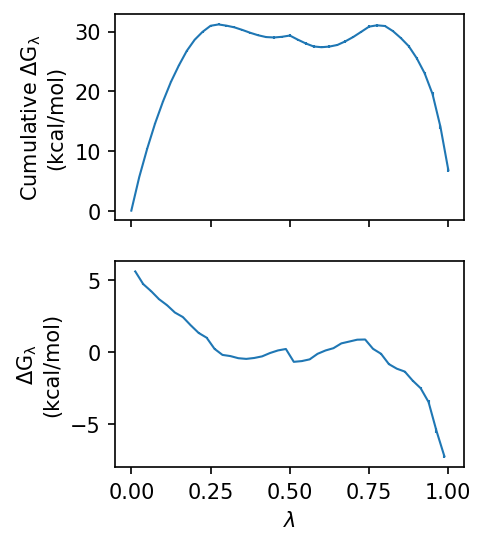

In [37]:
fig, (cumAx, eachAx) = plt.subplots(2,1, sharex=True)
# Cumulative change in kT
cumAx.errorbar(l, f, yerr=errors, marker=None, linewidth=1)
cumAx.set(ylabel=r'Cumulative $\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker=None, linewidth=1)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

fig.set_figwidth(3)
plt.savefig(f'{path}dG_{affix}.pdf')
plt.show()

# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [219]:
def convergencePlot(theax, fs, ferr, bs, berr, RT, fwdColor='#0072B2', bwdColor='#D55E00', lgndF=None, lgndB=None):
    if not lgndF:
        lgndF=fwdColor
        lgndB=bwdColor
        
    theax.errorbar(np.arange(len(fs))/len(fs)+0.1, fs, yerr=ferr, marker='o', linewidth=1, color=fwdColor, markerfacecolor='white', markeredgewidth=1, markeredgecolor=fwdColor, ms=5)
    theax.errorbar(np.arange(len(bs))/len(fs)+0.1, bs, yerr=berr, marker='o', linewidth=1, color=bwdColor, markerfacecolor='white', markeredgewidth=1, markeredgecolor=bwdColor, ms=5, linestyle='--')

    theax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    finalMean = fs[-1]
    theax.axhline(y= finalMean, linestyle='-.', color='gray')
    theax.plot(0, finalMean, linewidth=1, color=lgndF, label='Forward Time Sampling')
    theax.plot(0, finalMean, linewidth=1, color=lgndB, linestyle='--', label='Backward Time Sampling')
    
    return theax

In [240]:
def subSample(unkGrps, lowPct, hiPct):
    partial = []
    for key, group in unkGrps:
        last = group.index.get_level_values(0)[-1]
        first = group.index.get_level_values(0)[0]
        nsteps = last-first
        
        lowBnd = nsteps*lowPct+first
        hiBnd = nsteps*hiPct+first
        indices = group.index.get_level_values(0)
        mask = np.logical_and(indices<=hiBnd, indices>=lowBnd) 
        
        partial.append(group.loc[mask])

    partial = pd.concat(partial)
    
    return partial
    
    
def doConvergence(u_nk, tau=1):
    groups = u_nk.groupby('fep-lambda')

    #return data_list
    
    forward = []
    forward_error = []
    backward = []
    backward_error = []
    num_points = 10
    for i in range(1, num_points+1):
        # forward
        partial = subSample(groups, 0, i/num_points)
        estimate = BAR().fit(partial)
        l, l_mid, f, df, ddf, errors = get_BAR(estimate)
        
        forward.append(f.iloc[-1])
        forward_error.append(errors[-1])


        partial = subSample(groups, (1-i/num_points), 1)
        estimate = BAR().fit(partial)
        l, l_mid, f, df, ddf, errors = get_BAR(estimate)
        
        backward.append(f.iloc[-1])
        backward_error.append(errors[-1])

    return forward, forward_error, backward, backward_error

    
def altConvergence(u_nk, nbins):
    groups = u_nk.groupby('fep-lambda')

    #return data_list
    
    forward = []
    forward_error = []
    backward = []
    backward_error = []
    num_points = nbins
    for i in range(1, num_points+1):
        # forward
        partial = subSample(groups, (i-1)/num_points, i/num_points)
        estimate = BAR().fit(partial)
        l, l_mid, f, df, ddf, errors = get_BAR(estimate)
        
        forward.append(f.iloc[-1])
        forward_error.append(errors[-1])

    return forward, forward_error

In [259]:
def doConvPlot(ax, X, fs, ferr, fwdColor):
    ax.errorbar(X, fs, yerr=ferr, marker='o', linewidth=1, color=fwdColor, markerfacecolor='white', markeredgewidth=1, markeredgecolor=fwdColor, ms=5)
    return ax

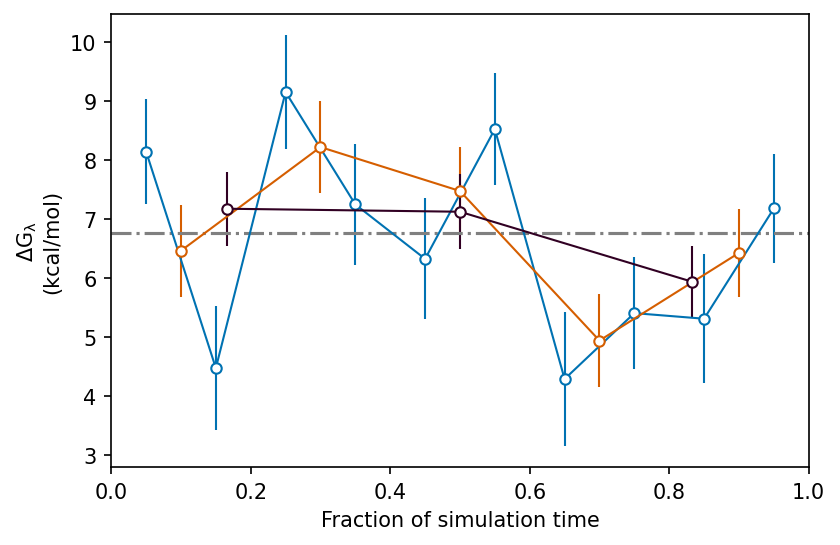

In [264]:
fwdColor='#0072B2'
bwdColor='#D55E00'
fig, ax = plt.subplots(1,1)

nbins = 10
fs, Err = altConvergence(u_nk, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs, Err, fwdColor)

nbins = 5
fs, Err = altConvergence(u_nk, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs, Err, bwdColor)

nbins=3
fs, Err = altConvergence(u_nk, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs, Err, "#310023")

ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

finalMean = f.iloc[-1]
ax.axhline(y= finalMean, linestyle='-.', color='gray')
#ax.plot(0, finalMean, linewidth=1, color=fwdColor)
ax.set(xlim=(0,1))
#ax.legend()
ax.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)', xlabel='Fraction of simulation time')
plt.show()

In [266]:
nbins=50
fs, Err = altConvergence(u_nk, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs, Err, "#310023")

ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

finalMean = f.iloc[-1]
ax.axhline(y= finalMean, linestyle='-.', color='gray')
#ax.plot(0, finalMean, linewidth=1, color=fwdColor)
ax.set(xlim=(0,1))
#ax.legend()
ax.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)', xlabel='Fraction of simulation time')
plt.show()

KeyError: 0.25

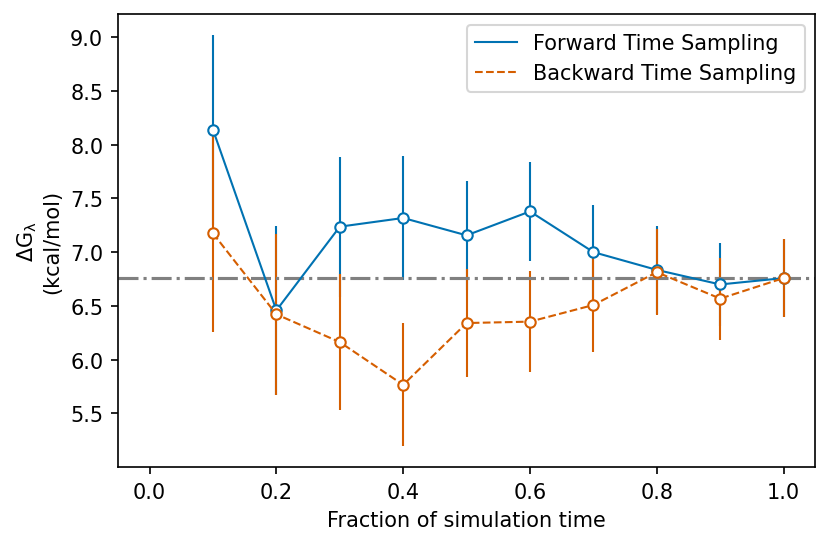

In [263]:
forward, fwdErr, backward, bwdErr = doConvergence(u_nk)
fig, ax = plt.subplots(1,1)
convergencePlot(ax, forward, fwdErr, backward, bwdErr, RT)
ax.legend()
ax.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)', xlabel='Fraction of simulation time')
plt.show()
#plt.savefig(f'{path}convergence_{affix}.png', dpi=600)

<AxesSubplot:xlabel='Fraction of the simulation time', ylabel='$\\Delta G$ (kT)'>

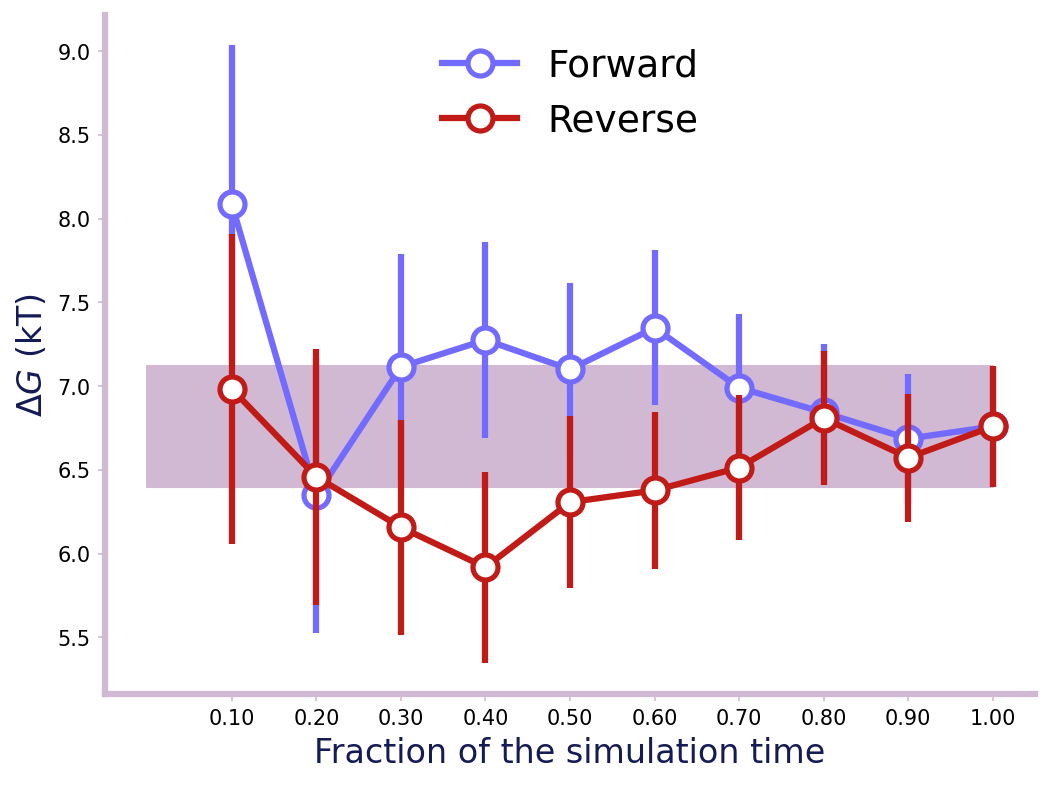

In [184]:
convergence_plot(u_nk, l)

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

The PDF is estimated with Scipy's Gaussian Kernel with automatic bandwidth determination

In [19]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

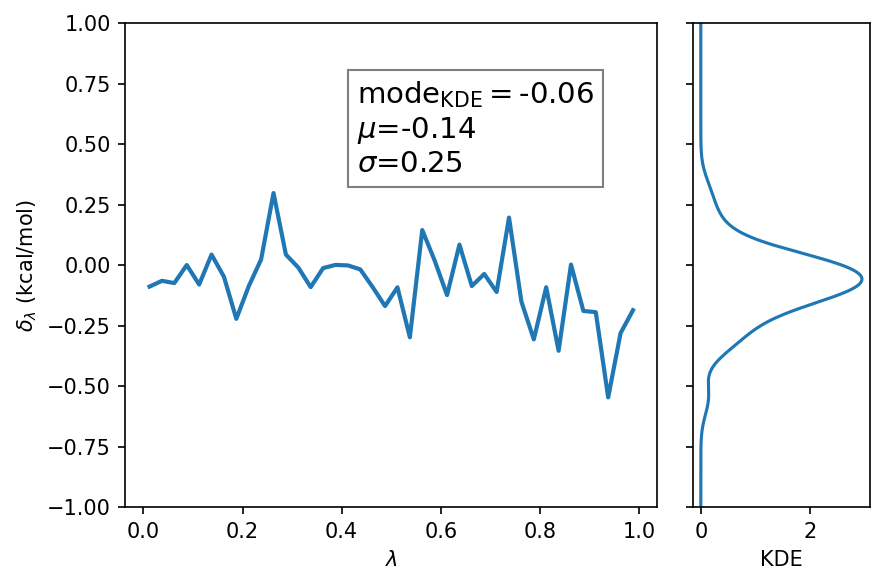

In [113]:
fig, (hystAx, pdfAx) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]})

diff = (dG_f + np.array(dG_b))*RT
hystAx.plot(l_mid, diff, linewidth=2)
hystAx.set(xlabel=r'$\lambda$', ylabel=r'$\delta_\lambda$ (kcal/mol)')
plt.ylim(-1,1)


pdfY, edges = np.histogram(diff, bins=20, density=True)
pdfX = (edges[1:] + edges[:-1])/2
#pdfAx.plot(pdfY, pdfX, label="histogrammed")


kernel = sp.stats.gaussian_kde(diff)
samples = np.linspace(-1, 1, 1000)
pdfAx.plot(kernel(samples), samples, label='KDE')

pdfAx.set(xlabel="KDE")
std = np.std(X)
mean = np.average(X)
mode = pd.Series(kernel(samples), index=samples).idxmax()
textstr = r"$\rm{mode_{KDE}=}$"+f"{np.round(mode,2)}"+"\n"+fr"$\mu$={np.round(mean,2)}"+"\n"+fr"$\sigma$={np.round(std,2)}"


props = dict(boxstyle='square', facecolor='white', alpha=0.5)
hystAx.text(0.35, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

fig.tight_layout()

plt.savefig(f"{path}discrepancies_{affix}.pdf")
plt.show()